In [25]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt


In [3]:
# Load dataset
hf = h5py.File("../epfl3.h5", "r")

In [7]:
# 1715 entries
# each entry : 112x112x32
# 32 slices
nb_entries = len(hf.keys()) 
list_keys = list(hf.keys())

# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(list_keys)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [8]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [9]:
# UNET architecture

vol_shape = (112, 112, 32) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

Instructions for updating:
Use fn_output_signature instead


In [20]:
# Load training set
slices_train_3d = np.zeros((len(keys_train),112,112,32))
for i, key in enumerate(keys_train):
    # Get the "frame" of the entry "key"
    # Normalize : dividing by 255 (RGB)
    slices_train_3d[i] = hf.get(key)["frame"][0]/255

# Load the validation set 
slices_test_3d = np.zeros((len(keys_test),112,112,32))
for i, key in enumerate(keys_test):
    slices_test_3d[i] = hf.get(key)["frame"][0]/255

In [21]:
# Adam optimizer learning rate
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

# Training
train_generator = vxm_data_generator(slices_train_3d, batch_size=8)
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=1);

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
5/5 [==============================] - 156s 31s/step - loss: 2.6888e-04 - vxm_dense_transformer_loss: 2.6886e-04 - vxm_dense_flow_loss: 5.1490e-07
Epoch 2/5
5/5 [==============================] - 150s 30s/step - loss: 2.8876e-04 - vxm_dense_transformer_loss: 2.8848e-04 - vxm_dense_flow_loss: 5.6509e-06
Epoch 3/5
5/5 [==============================] - 157s 31s/step - loss: 2.7251e-04 - vxm_dense_transformer_loss: 2.7113e-04 - vxm_dense_flow_loss: 2.7515e-05
Epoch 4/5
5/5 [==============================] - 157s 31s/step - loss: 2.8639e-04 - vxm_dense_transformer_loss: 2.8233e-04 - vxm_dense_flow_loss: 8.1237e-05
Epoch 5/5
5/5 [==============================] - 154s 31s/step - loss: 3.0823e-04 - vxm_dense_transformer_loss: 3.0437e-04 - vxm_dense_flow_loss: 7.7240e-05


In [26]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

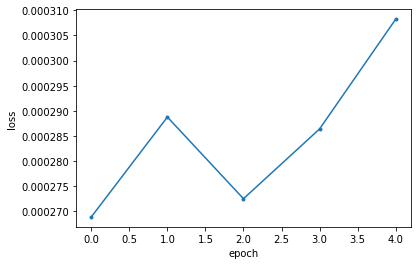

In [27]:
# Visualize the losses
plot_history(hist)

In [36]:
# Validation set generator
val_generator = vxm_data_generator(slices_test_3d, batch_size = 1)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

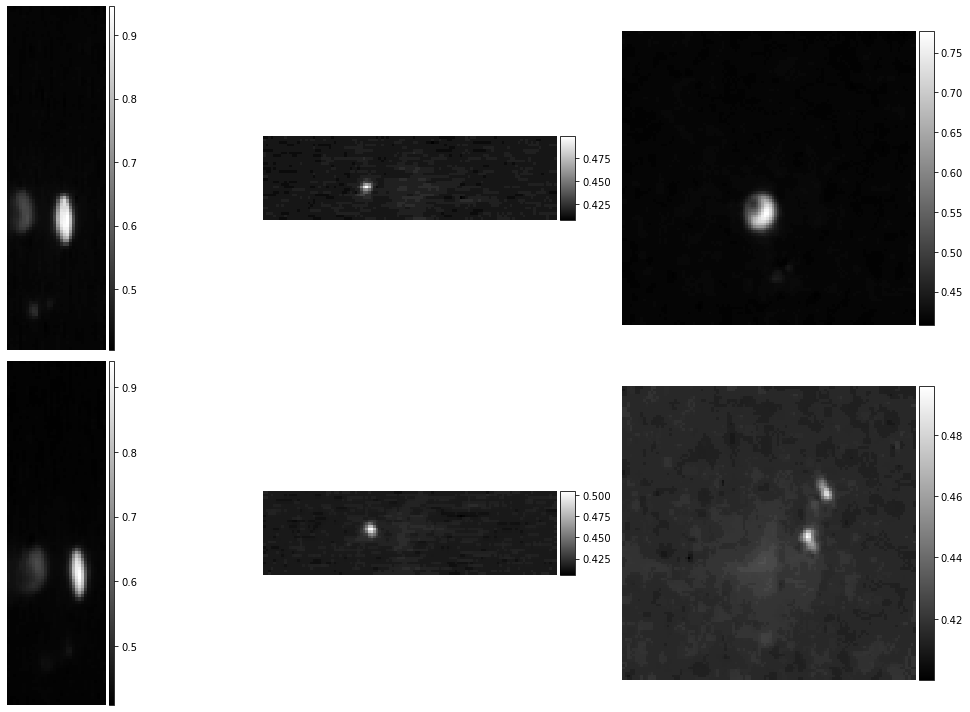

In [37]:
# Fixed image : Reference
mid_slices_fixed = [np.take(np.squeeze(val_input[1]), vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

# Prediction image : output
moved_pred = our_val_pred[0].squeeze()
mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

# Plot sagital, coronal & transverse planes
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

In [38]:
# If it looks ok => save the weights
vxm_model.save_weights("weights.keras")